# Prophet 

In [86]:
import numpy as np
import pandas as pd
import sidetable
import warnings
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from scipy import stats
import datetime
import statsmodels.api as sm
import itertools
from scipy.stats import boxcox
import fbprophet
from sklearn.metrics import mean_squared_error, r2_score
warnings.filterwarnings('ignore')

In [17]:
# !conda install -c conda-forge fbprophet -y

In [46]:
## load the data
qcell = pd.read_csv('data-for-test2.csv')

In [47]:
qcell.info() ## We can understand total 200000 observations 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   datetime     200000 non-null  object 
 1   irradiance   200000 non-null  float64
 2   humidity     200000 non-null  float64
 3   temperature  200000 non-null  float64
 4   energy       200000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 7.6+ MB


In [48]:
qcell['datetime'] = pd.to_datetime(qcell["datetime"])
qcell.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   datetime     200000 non-null  datetime64[ns]
 1   irradiance   200000 non-null  float64       
 2   humidity     200000 non-null  float64       
 3   temperature  200000 non-null  float64       
 4   energy       200000 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 7.6 MB


In [49]:
qcell.isnull().sum()

datetime       0
irradiance     0
humidity       0
temperature    0
energy         0
dtype: int64

In [50]:
df = qcell

In [51]:
df.shape

(200000, 5)

In [52]:
df.dtypes

datetime       datetime64[ns]
irradiance            float64
humidity              float64
temperature           float64
energy                float64
dtype: object

In [53]:
df['ds'] = df['datetime']
df['y'] = df['energy']

In [54]:
# set index of the dateframe
df.set_index('datetime')

,irradiance,humidity,temperature,energy,ds,y
datetime,,,,,,
2016-01-01 00:00:00,0.000,72.7,21.556,0.00,2016-01-01 00:00:00,0.00
2016-01-01 00:05:00,0.000,73.0,21.556,0.00,2016-01-01 00:05:00,0.00
2016-01-01 00:10:00,0.396,73.3,21.500,0.00,2016-01-01 00:10:00,0.00
2016-01-01 00:15:00,0.791,73.3,21.389,0.00,2016-01-01 00:15:00,0.00
2016-01-01 00:20:00,0.396,73.3,21.278,0.00,2016-01-01 00:20:00,0.00
...,...,...,...,...,...,...
2018-01-07 17:15:00,193.286,58.1,25.556,7.73,2018-01-07 17:15:00,7.73
2018-01-07 17:20:00,557.061,57.1,25.889,8.01,2018-01-07 17:20:00,8.01
2018-01-07 17:25:00,528.811,58.2,25.667,10.39,2018-01-07 17:25:00,10.39


In [55]:
df = df[(df.energy >  0) ] ## Two entries are dropped 
df.describe()

,irradiance,humidity,temperature,energy,y
count,91529.000000,91529.000000,91529.000000,91529.000000,91529.000000
mean,495.084828,54.502245,26.802165,10.062603,10.062603
std,753.518180,13.699910,121.221310,16.445438,16.445438
min,0.000000,0.000000,-17.778000,0.010000,0.010000
25%,205.181000,49.000000,25.500000,5.000000,5.000000
50%,430.681000,54.800000,27.167000,9.700000,9.700000
75%,789.500000,61.300000,28.889000,14.800000,14.800000
max,144552.000000,89.800000,25948.800000,3390.000000,3390.000000


In [56]:
df

,datetime,irradiance,humidity,temperature,energy,ds,y
112,2016-01-01 09:25:00,23.335,86.6,14.889,1.00,2016-01-01 09:25:00,1.00
115,2016-01-01 09:40:00,100.063,85.7,15.389,1.00,2016-01-01 09:40:00,1.00
116,2016-01-01 09:45:00,118.257,85.4,15.778,1.00,2016-01-01 09:45:00,1.00
118,2016-01-01 09:55:00,157.017,84.3,16.556,1.00,2016-01-01 09:55:00,1.00
119,2016-01-01 10:00:00,178.374,82.9,17.056,1.00,2016-01-01 10:00:00,1.00
...,...,...,...,...,...,...,...
199995,2018-01-07 17:15:00,193.286,58.1,25.556,7.73,2018-01-07 17:15:00,7.73
199996,2018-01-07 17:20:00,557.061,57.1,25.889,8.01,2018-01-07 17:20:00,8.01
199997,2018-01-07 17:25:00,528.811,58.2,25.667,10.39,2018-01-07 17:25:00,10.39
199998,2018-01-07 17:30:00,347.915,58.3,25.889,8.74,2018-01-07 17:30:00,8.74


## Construct the Model on daily based data entry

In [57]:
# Apply Box-Cox Transform to value column and assign to new column y
df['y'], lam = boxcox(df['energy'])

In [58]:
m = fbprophet.Prophet()

In [59]:
m.fit(df)

In [78]:
future = m.make_future_dataframe(periods=30)

In [79]:
forecast = m.predict(future)

## Energy Forecasting for the next 30 days

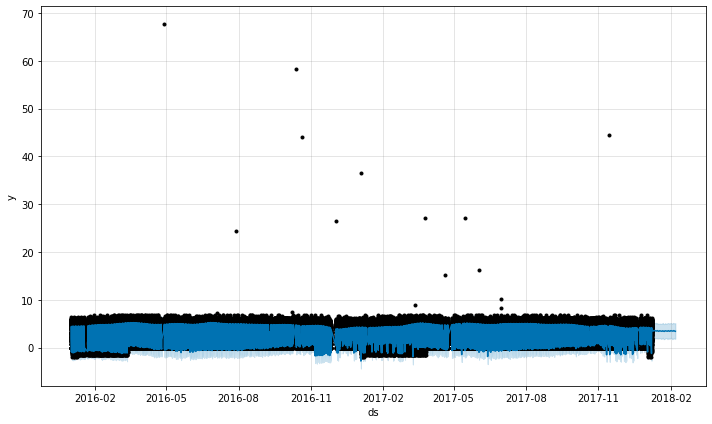

In [80]:
m.plot(forecast);

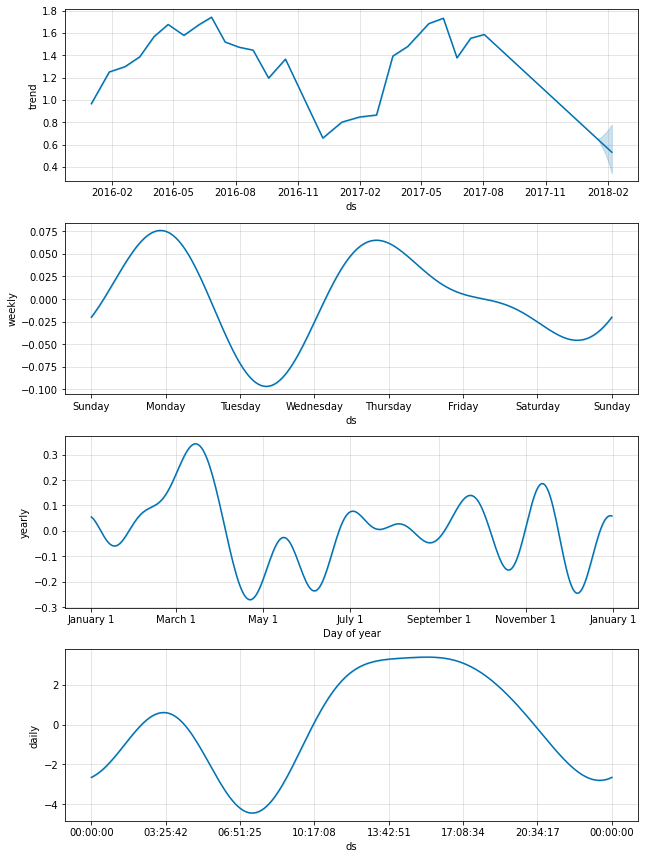

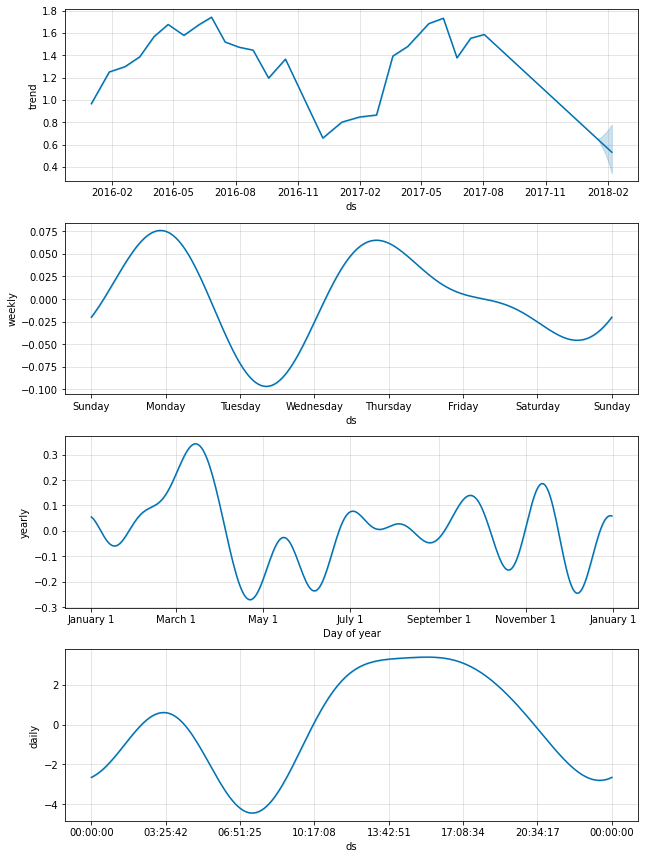

In [81]:
m.plot_components(forecast)

## Construct the Model on Weekly based data entry

In [60]:
df

,datetime,irradiance,humidity,temperature,energy,ds,y
112,2016-01-01 09:25:00,23.335,86.6,14.889,1.00,2016-01-01 09:25:00,0.000000
115,2016-01-01 09:40:00,100.063,85.7,15.389,1.00,2016-01-01 09:40:00,0.000000
116,2016-01-01 09:45:00,118.257,85.4,15.778,1.00,2016-01-01 09:45:00,0.000000
118,2016-01-01 09:55:00,157.017,84.3,16.556,1.00,2016-01-01 09:55:00,0.000000
119,2016-01-01 10:00:00,178.374,82.9,17.056,1.00,2016-01-01 10:00:00,0.000000
...,...,...,...,...,...,...,...
199995,2018-01-07 17:15:00,193.286,58.1,25.556,7.73,2018-01-07 17:15:00,3.219623
199996,2018-01-07 17:20:00,557.061,57.1,25.889,8.01,2018-01-07 17:20:00,3.303325
199997,2018-01-07 17:25:00,528.811,58.2,25.667,10.39,2018-01-07 17:25:00,3.954318
199998,2018-01-07 17:30:00,347.915,58.3,25.889,8.74,2018-01-07 17:30:00,3.513801


In [61]:
df1 = df.set_index("datetime")
df1

,irradiance,humidity,temperature,energy,ds,y
datetime,,,,,,
2016-01-01 09:25:00,23.335,86.6,14.889,1.00,2016-01-01 09:25:00,0.000000
2016-01-01 09:40:00,100.063,85.7,15.389,1.00,2016-01-01 09:40:00,0.000000
2016-01-01 09:45:00,118.257,85.4,15.778,1.00,2016-01-01 09:45:00,0.000000
2016-01-01 09:55:00,157.017,84.3,16.556,1.00,2016-01-01 09:55:00,0.000000
2016-01-01 10:00:00,178.374,82.9,17.056,1.00,2016-01-01 10:00:00,0.000000
...,...,...,...,...,...,...
2018-01-07 17:15:00,193.286,58.1,25.556,7.73,2018-01-07 17:15:00,3.219623
2018-01-07 17:20:00,557.061,57.1,25.889,8.01,2018-01-07 17:20:00,3.303325
2018-01-07 17:25:00,528.811,58.2,25.667,10.39,2018-01-07 17:25:00,3.954318


## Downsampling to week because modelling on daily basis takes a lot of time

In [63]:
# Creating a train dataset
# Downsampling to week because modelling on daily basis takes a lot of time
ts_week_prophet = df1.resample("W").mean()

In [64]:
ts_week_prophet 

,irradiance,humidity,temperature,energy,y
datetime,,,,,
2016-01-03,436.006172,55.007388,24.338377,9.011557,3.134692
2016-01-10,496.523905,57.828356,25.605223,10.117859,3.408575
2016-01-17,458.209282,59.856593,25.022315,9.868901,3.351415
2016-01-24,494.160599,60.773300,25.763438,10.272544,3.423530
2016-01-31,515.207192,59.758145,26.081787,10.301942,3.459860
...,...,...,...,...,...
2017-12-10,479.387838,52.509195,25.024621,10.015326,3.502256
2017-12-17,472.092600,57.749740,24.368926,9.876302,3.472536
2017-12-24,391.157430,58.032538,25.019974,8.147505,2.947839


In [65]:
ts_week_prophet['ds'] = ts_week_prophet.index
ts_week_prophet

,irradiance,humidity,temperature,energy,y,ds
datetime,,,,,,
2016-01-03,436.006172,55.007388,24.338377,9.011557,3.134692,2016-01-03
2016-01-10,496.523905,57.828356,25.605223,10.117859,3.408575,2016-01-10
2016-01-17,458.209282,59.856593,25.022315,9.868901,3.351415,2016-01-17
2016-01-24,494.160599,60.773300,25.763438,10.272544,3.423530,2016-01-24
2016-01-31,515.207192,59.758145,26.081787,10.301942,3.459860,2016-01-31
...,...,...,...,...,...,...
2017-12-10,479.387838,52.509195,25.024621,10.015326,3.502256,2017-12-10
2017-12-17,472.092600,57.749740,24.368926,9.876302,3.472536,2017-12-17
2017-12-24,391.157430,58.032538,25.019974,8.147505,2.947839,2017-12-24


In [67]:
m1 = fbprophet.Prophet()

In [68]:
m1.fit(ts_week_prophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [74]:
future = m1.make_future_dataframe(periods=52)

In [75]:
forecast = m1.predict(future)

## Energy Forecasting for the next three months 

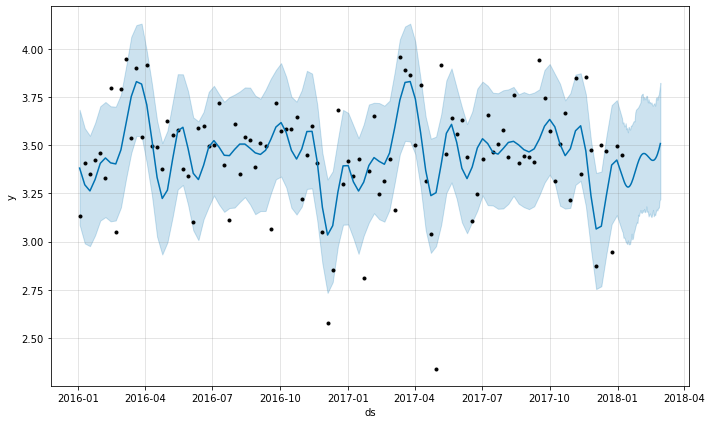

In [76]:
m1.plot(forecast);

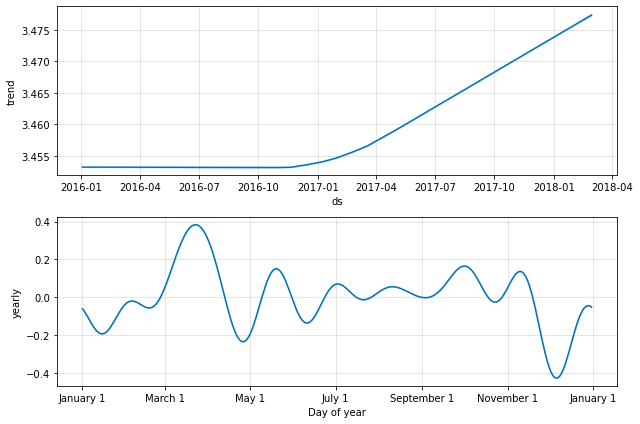

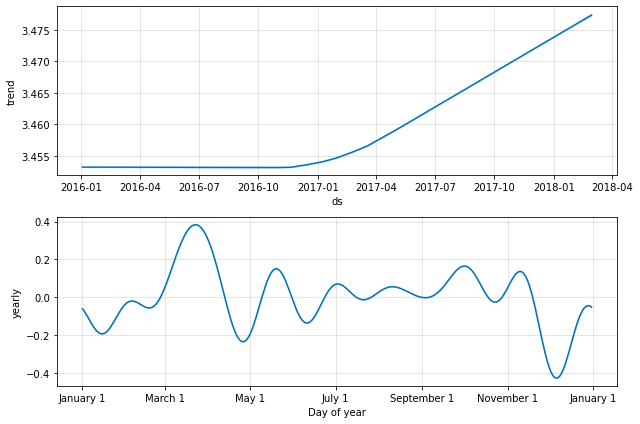

In [77]:
m1.plot_components(forecast)